In [1]:
pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=dc4d49390f9c1e8e4e2cf5859ae07d9755ee489ebb0310fc1a491fdb48f984a2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


Loaded pretrained weights for efficientnet-b3
Epoch 1/10


100%|██████████| 171/171 [02:44<00:00,  1.04it/s]


Train Loss: 0.6247, Train Accuracy: 0.8243
Val Loss: 0.0292, Val Accuracy: 0.9929
Epoch 2/10


100%|██████████| 171/171 [02:20<00:00,  1.22it/s]


Train Loss: 0.0756, Train Accuracy: 0.9785
Val Loss: 0.0067, Val Accuracy: 0.9989
Epoch 3/10


100%|██████████| 171/171 [02:14<00:00,  1.27it/s]


Train Loss: 0.0410, Train Accuracy: 0.9889
Val Loss: 0.0035, Val Accuracy: 0.9991
Epoch 4/10


100%|██████████| 171/171 [02:06<00:00,  1.35it/s]


Train Loss: 0.0282, Train Accuracy: 0.9920
Val Loss: 0.0030, Val Accuracy: 0.9995
Epoch 5/10


100%|██████████| 171/171 [02:10<00:00,  1.31it/s]


Train Loss: 0.0220, Train Accuracy: 0.9932
Val Loss: 0.0041, Val Accuracy: 0.9993
Epoch 6/10


100%|██████████| 171/171 [02:09<00:00,  1.32it/s]


Train Loss: 0.0156, Train Accuracy: 0.9962
Val Loss: 0.0038, Val Accuracy: 0.9982
Epoch 7/10


100%|██████████| 171/171 [02:17<00:00,  1.24it/s]


Train Loss: 0.0166, Train Accuracy: 0.9949
Val Loss: 0.0065, Val Accuracy: 0.9987
Epoch 8/10


100%|██████████| 171/171 [02:11<00:00,  1.30it/s]


Train Loss: 0.0181, Train Accuracy: 0.9942
Val Loss: 0.0022, Val Accuracy: 0.9993
Epoch 9/10


100%|██████████| 171/171 [02:01<00:00,  1.41it/s]


Train Loss: 0.0161, Train Accuracy: 0.9956
Val Loss: 0.0009, Val Accuracy: 0.9996
Epoch 10/10


100%|██████████| 171/171 [02:01<00:00,  1.40it/s]


Train Loss: 0.0127, Train Accuracy: 0.9969
Val Loss: 0.0033, Val Accuracy: 0.9995
Model saved successfully at efficientnet_b3_model_split_aug.pth


100%|██████████| 86/86 [01:19<00:00,  1.08it/s]


Test Loss: 0.0029, Test Accuracy: 0.9993

Test Classification Report:
              precision    recall  f1-score   support

    30cotton       1.00      1.00      1.00       218
    40cotton       1.00      1.00      1.00       213
    50cotton       1.00      1.00      1.00       202
    53cotton       0.99      1.00      1.00       227
    58cotton       1.00      1.00      1.00       224
    60cotton       1.00      1.00      1.00       181
    63cotton       1.00      1.00      1.00       216
    65cotton       1.00      1.00      1.00       197
    66cotton       1.00      0.99      1.00       214
    80cotton       1.00      1.00      1.00       211
    95cotton       1.00      1.00      1.00       217
    98cotton       1.00      1.00      1.00       215
    99cotton       1.00      1.00      1.00       196

    accuracy                           1.00      2731
   macro avg       1.00      1.00      1.00      2731
weighted avg       1.00      1.00      1.00      2731



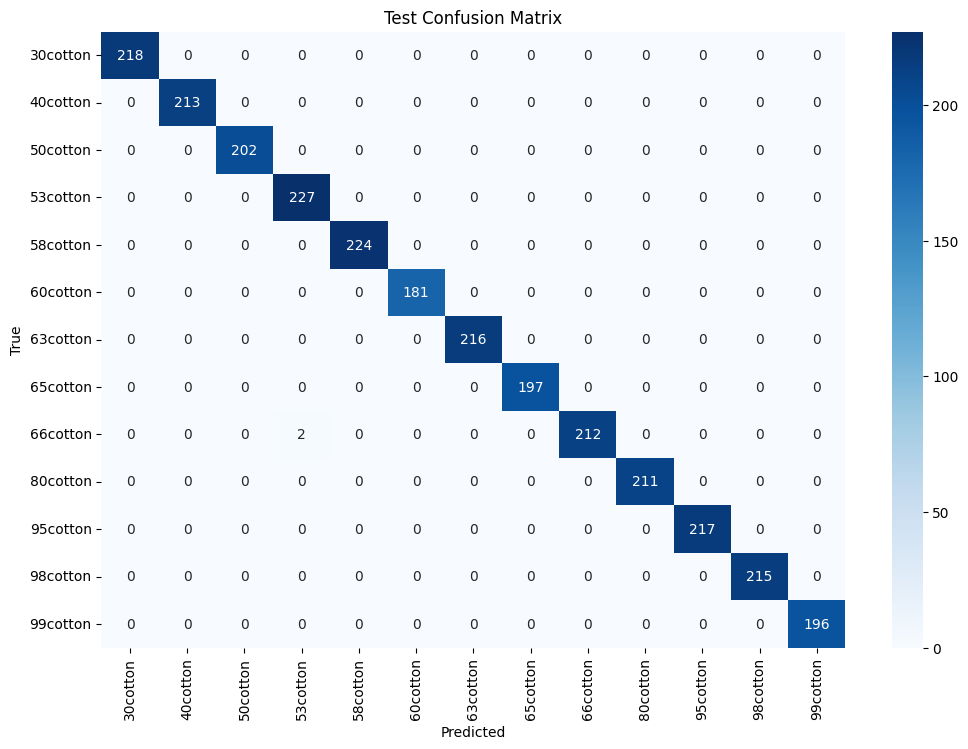

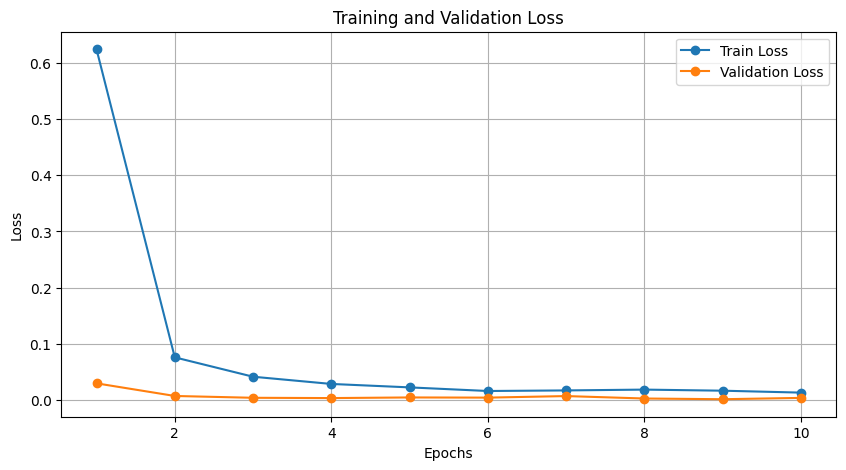

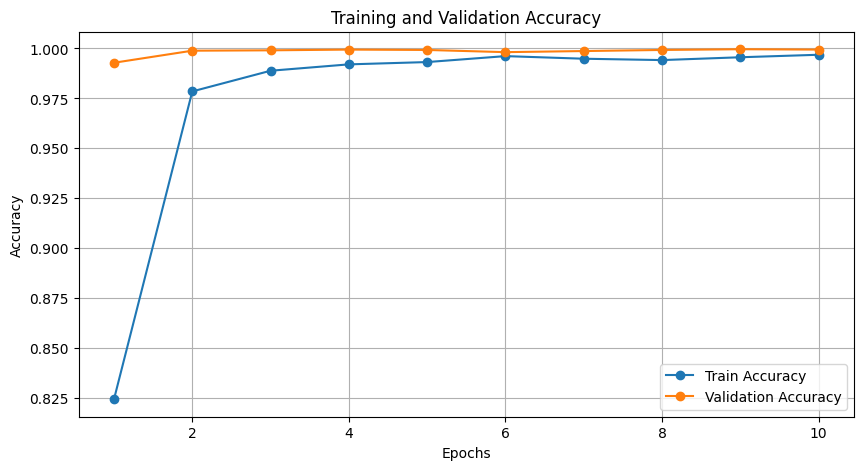


Final Test Metrics:
Test Accuracy: 0.9993
Test F1-Score (Weighted): 0.9993
Test Recall (Weighted): 0.9993


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet

# Dataset class
class CottonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))  # Class names from folder structure

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")  # Ensure RGB channels
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None  # Skip this image if an error occurs

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Adjust size for EfficientNet
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Adjust size for EfficientNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Dataset path
data_dir = "/kaggle/input/cotton/CottonFabricImageBD/Augmented"

# Initialize the dataset
full_dataset = CottonDataset(data_dir, transform=None)

# Calculate the number of training, validation, and test samples
total_samples = len(full_dataset)
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply specific transforms to train, validation, and test datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load the pre-trained EfficientNetB3 model
model = EfficientNet.from_pretrained('efficientnet-b3')

# Modify the classifier for the number of classes in the dataset
num_classes = len(full_dataset.class_names)
model._fc = nn.Linear(in_features=model._fc.in_features, out_features=num_classes)

# Send model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        if images is None:  # Skip if image is None (corrupted)
            continue

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader):
            if images is None:  # Skip if image is None (corrupted)
                continue

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), correct / total, all_preds, all_labels

# Initialize lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

# Save the trained model
model_save_path = "efficientnet_b3_model_split_aug.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully at {model_save_path}")

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Classification report and confusion matrix for test set
print("\nTest Classification Report:")
print(classification_report(test_labels, test_preds, target_names=full_dataset.class_names))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=full_dataset.class_names, yticklabels=full_dataset.class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Confusion Matrix")
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Final Test Metrics
accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds, average="weighted")
recall = recall_score(test_labels, test_preds, average="weighted")

print(f"\nFinal Test Metrics:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score (Weighted): {f1:.4f}")
print(f"Test Recall (Weighted): {recall:.4f}")
